In [290]:
import torch

X = torch.normal(0,1,(3,3))

print(X.shape)

print(torch.rand(X.shape))
print(X)

print(torch.zeros_like(X).shape)
print(torch.zeros(X.shape).shape)

torch.Size([3, 3])
tensor([[0.1727, 0.3141, 0.0658],
        [0.7762, 0.1499, 0.1428],
        [0.5848, 0.4752, 0.3157]])
tensor([[-0.7676,  0.4082,  0.6416],
        [-0.5875,  1.4564, -1.2819],
        [ 0.4942,  0.1898, -0.3510]])
torch.Size([3, 3])
torch.Size([3, 3])


In [291]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    
    if dropout == 1:
        # drop everything
        return torch.zeros_like(X)
    
    if dropout == 0:
        # return everything
        return X
    
    mask = (torch.rand(X.shape) > dropout).float()
    
#     print(mask)
    
    return mask * X /(1.0 - dropout)

In [292]:
dropout_layer(X, 0.6)

tensor([[-1.9191,  0.0000,  0.0000],
        [-0.0000,  3.6410, -0.0000],
        [ 1.2354,  0.0000, -0.0000]])

In [293]:
dropout_layer(X, 0)

tensor([[-0.7676,  0.4082,  0.6416],
        [-0.5875,  1.4564, -1.2819],
        [ 0.4942,  0.1898, -0.3510]])

In [294]:
dropout_layer(X,1)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

### Working with fashion mnist

In [295]:
num_inputs, num_outputs , num_hidden1, num_hidden2 = 784, 10, 256, 256

In [296]:
# defining the model probability at each neural layer

dropout1 = 0.2
dropout2 = 0.5

from torch import nn

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2,is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()
        self.drop = dropout_layer
    
    def forward(self, X):
        out = self.relu(self.lin1(X.reshape(-1,num_inputs)))
        
        if self.training:
            out = self.drop(out, dropout1)
        
        out = self.relu(self.lin2(out))
        
        if self.training:
            out = self.drop(out, dropout2)
        
        out = self.lin3(out)
        
        return out
        
        

In [297]:
net = Net(num_inputs, num_outputs, num_hidden1, num_hidden2)

In [298]:
X = torch.normal(0,1, (1,784))

In [299]:
net(X)

tensor([[ 0.1232, -0.1415, -0.0271, -0.0285, -0.0195, -0.0169, -0.1080, -0.1367,
         -0.1622,  0.1016]], grad_fn=<AddmmBackward>)

In [300]:
import torchvision

my_transforms = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(root="../data", train=True, download=False, transform=my_transforms)

test_dataset = torchvision.datasets.FashionMNIST(root="../data", train=False, download=False, transform=my_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=256)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=256)


In [301]:
def get_label_from_tensor(y):
    text_labels = [
't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
'sneaker', 'bag', 'ankle boot']
    
    return text_labels[int(y)]

pullover


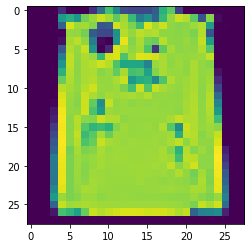

In [302]:
import matplotlib.pyplot as plt

for X,y in train_dataloader:
#     print(X[0].permute(1,2,0).shape)
    plt.imshow(X[0].permute(1,2,0))
    print(get_label_from_tensor(y[0]))
    break

In [303]:
net

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

for epoch 0 train loss : 0.008840924128890038 test loss : 0.009028126485645771
for epoch 1 train loss : 0.008619562722742558 test loss : 0.008803851902484894
for epoch 2 train loss : 0.008319727145135403 test loss : 0.008497677743434906
for epoch 3 train loss : 0.007892957888543606 test loss : 0.0080686891451478
for epoch 4 train loss : 0.007311051711440086 test loss : 0.007463990245014429
for epoch 5 train loss : 0.0066403113305568695 test loss : 0.006794624496251345
for epoch 6 train loss : 0.0063113803043961525 test loss : 0.006433718837797642
for epoch 7 train loss : 0.008495503105223179 test loss : 0.008745254017412663
for epoch 8 train loss : 0.01092146523296833 test loss : 0.011123285628855228
for epoch 9 train loss : 0.009966829791665077 test loss : 0.010131824761629105


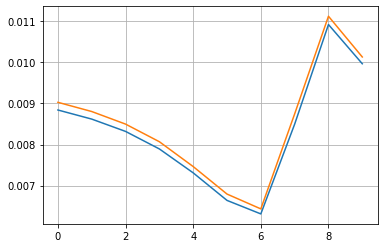

In [304]:
num_epochs, lr, batch_size = 10, 0.5, 256

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

def evaluate_loss(net, train_iter, loss):
    
    with torch.no_grad():
        current_loss =0
        current_number = 0
        net.eval()
        for X , y in train_iter:
            current_loss += loss(net(X), y)
            current_number += len(y)
    
    return current_loss/ current_number

train_loss_array = []
test_loss_array = []

for epoch in range(num_epochs):
    y_hat = net(X)
    l =  loss(y_hat, y)
    
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    current_train_loss = evaluate_loss(net, train_dataloader, loss)
    current_test_loss = evaluate_loss(net, test_dataloader, loss)
    
    train_loss_array.append(current_train_loss)
    test_loss_array.append(current_test_loss)
    
    print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")
    
     

plt.plot(range(num_epochs), train_loss_array)
plt.plot(range(num_epochs), test_loss_array)
plt.grid(True)
plt.show()
    
    


tensor([[ 0.5935,  2.5595, -1.3834,  1.7144, -0.3268, -0.8205, -0.0852, -1.5266,
          0.1123, -1.0928]])
tensor(1)
predicted:  trouser
base_truth: dress


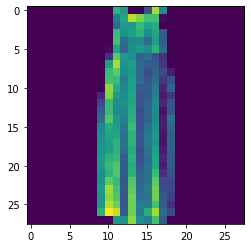

In [305]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():
    print(net(X[0]))

    print(torch.argmax(net(X[0])))

    print("predicted: ", get_label_from_tensor(torch.argmax(net(X[0]))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

### Concise implementation

In [306]:
def evaluate_loss(net, train_iter, loss):
    
    with torch.no_grad():
        current_loss =0
        current_number = 0
        net.eval()
        for X , y in train_iter:
            current_loss += loss(net(X), y)
            current_number += len(y)
    
    return current_loss/ current_number


In [307]:
net_concise = nn.Sequential( nn.Flatten(), nn.Linear(num_inputs, num_hidden1), nn.ReLU(), nn.Dropout(dropout1), nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), nn.Dropout(dropout2),
                     nn.Linear(num_hidden2, num_outputs))

def init_params(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_concise.apply(init_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

predicted (before training):  trouser
base_truth: trouser


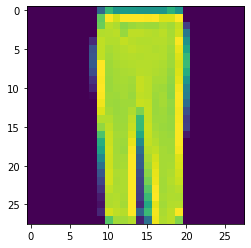

In [308]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():

    print("predicted (before training): ", get_label_from_tensor(torch.argmax(net_concise(X[0].reshape(-1,784)))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

for epoch 0 train loss : 0.008778833784162998 test loss : 0.008963624946773052
for epoch 1 train loss : 0.008674544282257557 test loss : 0.008864648640155792
for epoch 2 train loss : 0.008533491753041744 test loss : 0.008715088479220867
for epoch 3 train loss : 0.008353281766176224 test loss : 0.0085263941437006
for epoch 4 train loss : 0.008131208829581738 test loss : 0.008306392468512058
for epoch 5 train loss : 0.007859780453145504 test loss : 0.008028408512473106
for epoch 6 train loss : 0.007515678182244301 test loss : 0.007677939720451832
for epoch 7 train loss : 0.007079688832163811 test loss : 0.007233103271573782
for epoch 8 train loss : 0.006630267947912216 test loss : 0.00678782444447279
for epoch 9 train loss : 0.006246671080589294 test loss : 0.006393293850123882
for epoch 10 train loss : 0.009768817573785782 test loss : 0.010069120675325394
for epoch 11 train loss : 0.014442304149270058 test loss : 0.014772947877645493
for epoch 12 train loss : 0.008686701767146587 test l

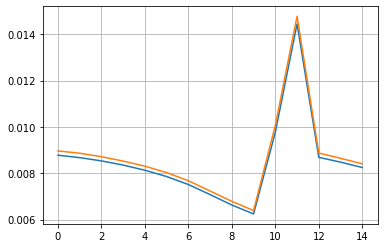

In [310]:
train_loss_array = []
test_loss_array = []

num_epochs, lr, batch_size = 15, 0.5, 256

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_concise.parameters(), lr=lr)


for epoch in range(num_epochs):
    current_train_loss = 0
    current_test_loss = 0
    for X, y in train_dataloader:
        y_hat = net_concise(X)
        l =  loss(y_hat, y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        current_train_loss += evaluate_loss(net_concise, train_dataloader, loss)
        current_test_loss += evaluate_loss(net_concise, test_dataloader, loss)

    train_loss_array.append(current_train_loss)
    test_loss_array.append(current_test_loss)
    
    print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")
    
     

plt.plot(range(num_epochs), train_loss_array)
plt.plot(range(num_epochs), test_loss_array)
plt.grid(True)
plt.show()


predicted:  trouser
base_truth: pullover


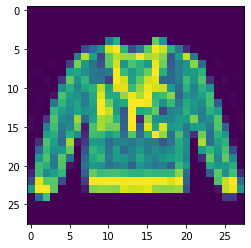

In [311]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():

    print("predicted: ", get_label_from_tensor(torch.argmax(net(X[0].reshape(-1,784)))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

## Exercises
1. What happens if you change the dropout probabilities for the first and second layers? In
particular, what happens if you switch the ones for both layers? Design an experiment to
answer these questions, describe your results quantitatively, and summarize the qualitative
takeaways.
2. Increase the number of epochs and compare the results obtained when using dropout with
those when not using it.
3. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
4. Why is dropout not typically used at test time?
5. Using the model in this section as an example, compare the effects of using dropout and
weight decay. What happens when dropout and weight decay are used at the same time?
Are the results additive? Are there diminished returns (or worse)? Do they cancel each other
out?
6. What happens if we apply dropout to the individual weights of the weight matrix rather than
the activations?
7. Invent another technique for injecting random noise at each layer that is different from the
standard dropout technique. Can you develop a method that outperforms dropout on the
Fashion-MNIST dataset (for a fixed architecture)?


In [312]:
#1

def design_net(dropout1, dropout2):
    net_concise = nn.Sequential( nn.Flatten(), nn.Linear(num_inputs, num_hidden1), nn.ReLU(), nn.Dropout(dropout1), 
                                nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), nn.Dropout(dropout2),
                                nn.Linear(num_hidden2, num_outputs))

    def init_params(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    net_concise.apply(init_params)
    
    return net_concise

In [318]:
def train_net_and_plot(net, num_epochs=8, wd=None):
    train_loss_array = []
    test_loss_array = []

    lr, batch_size = 0.5, 256

    loss = nn.CrossEntropyLoss()
    if (wd):
        optimizer = torch.optim.SGD(net_concise.parameters(), lr=lr, weight_decay=wd)
    else:  
        optimizer = torch.optim.SGD(net_concise.parameters(), lr=lr)


    for epoch in range(num_epochs):
        current_train_loss = 0
        current_test_loss = 0
        for X, y in train_dataloader:
            y_hat = net(X)
            l =  loss(y_hat, y)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            current_train_loss += evaluate_loss(net_concise, train_dataloader, loss)
            current_test_loss += evaluate_loss(net_concise, test_dataloader, loss)

        train_loss_array.append(current_train_loss)
        test_loss_array.append(current_test_loss)

        print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")



    plt.plot(range(num_epochs), train_loss_array)
    plt.plot(range(num_epochs), test_loss_array)
    plt.grid(True)
    plt.show()
    print(f"final train loss : {current_train_loss} test loss : {current_test_loss}")



In [ ]:
# to find the what happenswhen we switch dropout

train_net_and_plot(design_net(0.2, 0.6))

In [ ]:
train_net_and_plot(design_net(0.6, 0.2))

In [ ]:
#2 

# trying to find the dropout use

train_net_and_plot(design_net(0, 0))

In [ ]:
# 4

# not used at runtime because we want that dropout not to take out features that are important


# 5

# using weight decay and dropout

train_net_and_plot(design_net(0.2, 0.6), wd=0.3)

In [ ]:
# just using wd

train_net_and_plot(design_net(0,0), wd=0.3)

# just using dropout works better than using together with weight decay

In [ ]:
# 6

class Net_exp(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, dropout1, dropout2, dropout_to_weight=False, print_variance=False):
        super(Net_exp, self).__init__()
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.print_variance = print_variance
        self.dropout_to_weight = dropout_to_weight
        self.relu = nn.ReLU()
    
    def forward(self, X):
        if(self.dropout_to_weight==False):

            out = self.relu(self.lin1(X))
            if(self.print_variance):
                print(torch.var(out.detach()))

            out = dropout_layer(out, self.dropout1)
            out = self.relu(self.lin2(out))
            
            if(self.print_variance):
                print(torch.var(out.detach()))

            out = dropout_layer(out, self.dropout2)
            out = self.lin3(out)

            return out
        else:
            # apllying dropout to weight
            out = self.lin1(X)
            out = dropout_layer(out, self.dropout1)
            out = self.relu(out)
            out = self.lin2(out)
            out = dropout_layer(out, self.dropout2)
            out = self.relu(out)
            out = self.lin3(out)

            return out

In [ ]:
# 3

# printing variance
# with dropout
net_exp = Net_exp(num_inputs, num_outputs, num_hidden1, num_hidden2,0.2,0.5,print_variance=True)

def init_parma(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_exp.apply(init_parma)

In [ ]:
X1 = torch.normal(0, 0.1, (1, 784))

net_exp(X1)

In [ ]:
# printing variance
# without dropout
net_exp = Net_exp(num_inputs, num_outputs, num_hidden1, num_hidden2,0,0,print_variance=True)

def init_parma(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_exp.apply(init_parma)

net_exp(X1)

In [ ]:
# adding dropout to weight

net_exp = Net_exp(num_inputs, num_outputs, num_hidden1, num_hidden2,0.2,0.5, dropout_to_weight=True)

def init_parma(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_exp.apply(init_parma)

net_exp(X1)

In [ ]:
new_net = design_net(0.2,0.5)

new_net(X1)

In [ ]:
# train_net_and_plot(design_net(0.2, 0.6))

In [ ]:
# train_net_and_plot(new_net)

In [ ]:
#7 Another technique forinjecting randomnoise

# we can put an epsilon value into the neuralnetwork


class net_epsilon(nn.Module):
    def __init__(self, num_inputs=784, num_outputs=10, num_hidden1=256, num_hidden2=256, epsilon_m=0.02, epsilon_d=0.02):
        super(net_epsilon, self).__init__()
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()
        self.epsilon_m = epsilon_m
        self.epsilon_d = epsilon_d
        self.num_inputs = num_inputs
    
    def forward(self, X):
        out = self.relu(self.lin1(X.reshape(-1,self.num_inputs)))
        out = out + torch.normal(self.epsilon_m, self.epsilon_d, (out.shape))
        out = self.relu(self.lin2(X.reshape(-1, self.num_inputs)))
        out = out + torch.normal(self.epsilon_m, self.epsilon_d, (out.shape))
        out = self.lin3(out)

In [ ]:
net = net_epsilon()
net(X1)

In [ ]:
train_net_and_plot(net)